$$
\LaTeX macros
\newcommand{\pba}{{p^b_a}}
\newcommand{\de}{{\dot{e}}}
\newcommand{\dde}{{\ddot{e}}}
\newcommand{\pbd}{{p^b_d}}
\newcommand{\dpba}{{\dot{p}^b_a}}
\newcommand{\ddpba}{{\ddot{p}^b_a}}
\newcommand{\dpbd}{{\dot{p}^b_d}}
\newcommand{\ddpbd}{{\ddot{p}^b_d}}
\newcommand{\pag}{{p^a_g}}
\newcommand{\pav}{{p^a_v}}
\newcommand{\dpag}{{\dot{p}^a_g}}
\newcommand{\pai}{{p^a_i}}
\newcommand{\dpai}{{\dot{p}^a_i}}
\newcommand{\pbg}{{p^b_g}}
\newcommand{\dpbg}{{\dot{p}^b_g}}
\newcommand{\ddpbg}{{\ddot{p}^b_g}}
\newcommand{\pbi}{{p^b_i}}
\newcommand{\dpbi}{{\dot{p}^b_i}}
\newcommand{\ddpbi}{{\ddot{p}^b_i}}
\newcommand{\Rba}{{R^b_a}}
\newcommand{\dRba}{{\dot{R}{}^b_a}}
\newcommand{\ddRba}{{\ddot{R}{}^b_a}}
\newcommand{\Rab}{{R^a_b}}
\newcommand{\omaa}{{\omega^a_a}}
\newcommand{\domaa}{{\dot{\omega}{}^a_a}}
\newcommand{\Somaa}{{S\left(\omega^a_a\right)}}
\newcommand{\dSomaa}{{S\left(\dot{\omega}{}^a_a\right)}}
\newcommand{\Spag}{{S\left(p^a_g\right)}}
\newcommand{\Spai}{{S\left(p^a_i\right)}}
\newcommand{\nuaa}{{\nu^a_a}}
\newcommand{\dnuaa}{{\dot{\nu}{}^a_a}}
\newcommand{\Fb}{{F^b}}
\newcommand{\Fa}{{F^a}}
\newcommand{\Fg}{{F_g}}
\newcommand{\Fv}{{F_v}}
\newcommand{\Ng}{{N_g}}
\newcommand{\Nv}{{N_v}}
\newcommand{\Fe}{{F^{ext}}}
\newcommand{\Na}{{N^a}}
\newcommand{\iM}{{M^{-1}}}
\newcommand{\BM}{\left[\begin{matrix}}
\newcommand{\EBM}{\end{matrix}\right]}
\newcommand{\gamaa}{{\gamma^a_a}}
\newcommand{\dgamaa}{{\dot{\gamma}{}^a_a}}
\newcommand{\vx}{\vec{x}}
\newcommand{\vt}{\vec{\tau}}
\newcommand{\vn}{\vec{\nu}}
\newcommand{\T}{^\top}
\newcommand{\o}[1]{{\overline{#1}}}
\newcommand{\d}[2]{{\frac{\partial #1}{\partial #2}}}
\newcommand{\xpba}{{\,}^x{\!}p^b_a}
\newcommand{\ypba}{{\,}^y{\!}p^b_a}
$$


# Lab 03 - Control of a quadrotor
In this exercise model of flying robot is specified with actuation system characteristic for quadrotor.
Than control algorithm for altitude and pose stabilisation is implemented.

## The model of a flying robot
At the beginning let import all necessary libraries: 

In [1]:
from sympy import *
from sympy.plotting import plot
from sympy.matrices import matrix_multiply_elementwise as mme
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import functools

Next define all variables used to define equation of the robot:

In [2]:
t = symbols('t')

# Flying robot
phi_, tta_, psi_ = symbols('\phi \\theta \psi', cls=Function)
phi, tta, psi = phi_(t), tta_(t), psi_(t)

m, Ix, Iy, Iz = symbols('m I_x I_y I_z') # mass and inertia
u_,v_,w_,p_,q_,r_ = symbols('u v w p q r', cls=Function)
u,v,w,p,q,r = u_(t),v_(t),w_(t),p_(t),q_(t),r_(t)
xpag, ypag, zpag = symbols('{\\\,}^x{\\!}p^a_g {\\\,}^y{\\!}p^a_g {\\\,}^z{\\!}p^a_g')

grav, rho, Vol = symbols('g \\rho_{air} V') # earth acceleration, air density, object volume
xpav, ypav, zpav = symbols('{\\\,}^x{\\!}p^a_v {\\\,}^y{\\!}p^a_v {\\\,}^z{\\!}p^a_v')
pav = Matrix([xpav,ypav,zpav])

# aerodynamical coeffiecients
uCd, vCd, wCd, pCd, qCd, rCd = symbols('{\\\,}^u{\\!}C_d {\\\,}^v{\\!}C_d {\\\,}^w{\\!}C_d {\\\,}^p{\\!}C_d {\\\,}^q{\\!}C_d {\\\,}^r{\\!}C_d')
uCl, vCl, pCl, qCl, rCl = symbols('{\\\,}^u{\\!}C_l {\\\,}^v{\\!}C_l {\\\,}^p{\\!}C_l {\\\,}^q{\\!}C_l {\\\,}^r{\\!}C_l')

tauu_,tauv_,tauw_,taup_,tauq_,taur_ = symbols('\\tau_u \\tau_v \\tau_w \\tau_p \\tau_q \\tau_r', cls=Function)
tauu,tauv,tauw,taup,tauq,taur = tauu_(t),tauv_(t),tauw_(t),taup_(t),tauq_(t),taur_(t)
tau = Matrix([tauu,tauv,tauw,taup,tauq,taur])

tauus,tauvs,tauws,taups,tauqs,taurs = symbols('\overline{\\tau}_u \overline{\\tau}_v \overline{\\tau}_w \overline{\\tau}_p \overline{\\tau}_q \overline{\\tau}_r', cls=Function)
taus = Matrix([tauus,tauvs,tauws,taups,tauqs,taurs])

us,vs,ws,ps,qs,rs = symbols('\o{u} \o{v} \o{w} \o{p} \o{q} \o{r}', constant=True)
gamaas = Matrix([us,vs,ws,ps,qs,rs])

Chi = Matrix([[phi,tta,psi]]).T
dChi = diff(Chi,t)

cN1, cN2, cN3, cN4, cN = symbols('c_{N1} c_{N2} c_{N3} c_{N4} c_{N}')
cF1, cF2, cF3, cF4, cF = symbols('c_{F1} c_{F2} c_{F3} c_{F4} c_{F}')
om1_, om2_, om3_, om4_ = symbols('\omega_1 \omega_2 \omega_3 \omega_4',cls=Function)
om1, om2, om3, om4 = om1_(t), om2_(t), om3_(t), om4_(t)
xpgE1, ypgE1, zpgE1 = symbols('{\\\,}^x{\\!}p^g_{E1} {\\\,}^y{\\!}p^g_{E1} {\\\,}^z{\\!}p^g_{E1}')
xpgE2, ypgE2, zpgE2 = symbols('{\\\,}^x{\\!}p^g_{E2} {\\\,}^y{\\!}p^g_{E2} {\\\,}^z{\\!}p^g_{E2}')
xpgE3, ypgE3, zpgE3 = symbols('{\\\,}^x{\\!}p^g_{E3} {\\\,}^y{\\!}p^g_{E3} {\\\,}^z{\\!}p^g_{E3}')
xpgE4, ypgE4, zpgE4 = symbols('{\\\,}^x{\\!}p^g_{E4} {\\\,}^y{\\!}p^g_{E4} {\\\,}^z{\\!}p^g_{E4}')
pgE1 = Matrix([xpgE1, ypgE1, zpgE1])
pgE2 = Matrix([xpgE2, ypgE2, zpgE2])
pgE3 = Matrix([xpgE3, ypgE3, zpgE3])
pgE4 = Matrix([xpgE4, ypgE4, zpgE4])
z_ax = Matrix([0,0,1])

x_, y_, z_ = symbols('x y z',cls=Function)
x, y, z = x_(t), y_(t), z_(t)
xs, ys, zs = symbols('\o{x} \o{y} \o{z}')
phis, ttas, psis = symbols('\o{\phi} \o{\\theta} \o{\psi}')
om1s,om2s,om3s,om4s = symbols('\o{\omega}_1 \o{\omega}_2 \o{\omega}_3 \o{\omega}_4')

xd,yd,zd,phid,ttad,psid = symbols('x_d y_d z_d \phi_d \\theta_d \psi_d')
eta = Matrix([x,y,z,phi,tta,psi])
dChi

Matrix([
[  Derivative(\phi(t), t)],
[Derivative(\theta(t), t)],
[  Derivative(\psi(t), t)]])

## Exercise 1:
Look close to defined variables, try to figure out what is their meaning. Compare names of variables with equations of motion 

Display some variables using `display` function.

In [3]:
## your code here




Now let define some helper functions:

In [4]:
def log_results(func):
    @functools.wraps(func)
    def w_dec(*args, **kwargs):
        res = func(*args, **kwargs)
        t_old = -1 if len(w_dec.t) == 0 else w_dec.t[-1]
        t_new = args[0]
        if t_new > t_old:
            w_dec.log.append(res)
            w_dec.t.append(args[0])
        else:
            f = filter(lambda x: x >= t_new, w_dec.t)
            idx = w_dec.t.index(next(f))
            w_dec.log = w_dec.log[0:idx]+[res]
            w_dec.t = w_dec.t[0:idx]+[t_new]
        return res
    w_dec.log = []
    w_dec.t = []
    return w_dec


Sk = lambda v: Matrix([[0, -v[2], v[1]],[v[2], 0, -v[0]],[-v[1], v[0], 0]])

def Rx(a):
    return Matrix([[1,0,0],
                  [0,cos(a),-sin(a)],
                  [0,sin(a),cos(a)]])

def Ry(a):
    return Matrix([[cos(a),0,sin(a)],
                  [0,1,0],
                  [-sin(a),0,cos(a)]])

def Rz(a):
    return Matrix([[cos(a),-sin(a),0],
                  [sin(a),cos(a),0],
                  [0,0,1]])

def Jac(R,dChi=dChi):
    dR = (diff(R,t))
    Sw = (R.T @ dR)
    omsw = Matrix([[Sw[(2,1)]],[Sw[(0,2)]],[Sw[(1,0)]]])
    iJ = simplify(omsw.jacobian(dChi))
    J = simplify(iJ.inverse())
    return J

def plot_results(sim,ctrl,traj):
    control = np.array([ctrl.log[ctrl.t.index(time)] for time in sim.t]).T
    trajectory = np.array([traj.log[traj.t.index(time)] for time in sim.t]).T
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(3,2,1)
    ax1.plot(sim.t,sim.y[0],label='x')
    ax1.plot(sim.t,sim.y[1],label='y')
    ax1.plot(sim.t,sim.y[2],label='z')
    ax1.legend(loc='best')
    ax1 = fig1.add_subplot(3,2,2)
    ax1.plot(sim.t,sim.y[3],label='$\phi$')
    ax1.plot(sim.t,sim.y[4],label='$\\theta$')
    ax1.plot(sim.t,sim.y[5],label='$\psi$')
    ax1.legend(loc='best')
    ax1 = fig1.add_subplot(3,2,3)
    ax1.plot(sim.t,sim.y[6],label='$u$')
    ax1.plot(sim.t,sim.y[7],label='$v$')
    ax1.plot(sim.t,sim.y[8],label='$w$')
    ax1.legend(loc='best')
    ax1 = fig1.add_subplot(3,2,4)
    ax1.plot(sim.t,sim.y[9],label='$p$')
    ax1.plot(sim.t,sim.y[10],label='$q$')
    ax1.plot(sim.t,sim.y[11],label='$r$')
    ax1.legend(loc='best')
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(1,1,1)
    ax2.plot(sim.t,control[0],label='$\omega_1$')
    ax2.plot(sim.t,control[1],label='$\omega_2$')
    ax2.plot(sim.t,control[2],label='$\omega_3$')
    ax2.plot(sim.t,control[3],label='$\omega_4$')
    ax2.legend(loc='best')
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(1,1,1)
    ax3.plot(sim.t,sim.y[2]-trajectory[2],label='$z-z_d$')
    ax3.plot(sim.t,sim.y[3]-trajectory[3],label='$\phi-\phi_d$')
    ax3.plot(sim.t,sim.y[4]-trajectory[4],label='$\\theta-\\theta_d$')
    ax3.plot(sim.t,sim.y[5]-trajectory[5],label='$\psi-\psi_d$')
    ax3.legend(loc='best')

Using [symbolic expression](https://www.sympy.org/en/index.html) let define componenets of the equations of motion, notice simplification of mass matrix $M$ and be patient:

In [5]:
Rba = (Rz(psi) @ Ry(tta) @ Rx(phi)) # RPY
Rab = Rba.T
Rba_num = lambdify((psi,tta,phi),Rba)
Jba = Jac(Rba)
Jab = simplify(Jba.inverse())
Jba_num = lambdify((phi,tta),Jba)
Eta = Rba.col_join(zeros(3)).row_join(zeros(3).col_join(Jba))
iEta = simplify(Eta.inverse())
iEta_num = lambdify((phi,tta,psi),iEta)
Eta_num = lambdify((phi,tta,psi),Eta)
dChi_num = lambdify((phi,tta,psi),dChi)
I, nu, omaa, pag = diag(Ix,Iy,Iz), Matrix([u,v,w]), Matrix([p,q,r]), Matrix([xpag,ypag,zpag]) # inertia tensor, linear and angular velocities, vector of position of the center of gravity in the local frame
M = (m*eye(3)).row_join(-m * Sk(pag)).col_join((m * Sk(pag)).row_join(I))
# iM = simplify(M.inv()) # symbolic inversion of a matrix is very time consumming
iM = simplify(M.subs({xpag:0,ypag:0,zpag:0}).inv())
C = (m*Sk(omaa)).row_join(-m*Sk(omaa)*Sk(pag)).col_join((m*Sk(pag)*Sk(omaa)).row_join(-Sk(omaa)*I))
# gravity
Fbg = Matrix([0,0,-m*grav])
Fag = Rab*Fbg
Nag = Sk(pag)*Fag
Gag = Fag.col_join(Nag)
# bouyancy
Fbv = Matrix([0,0,rho*grav*Vol])
Fav = Rab*Fbv
Nav = Sk(pav)*Fav
Gav = Fav.col_join(Nav)
# restoring forces
Gar = Gag+Gav
gamaa, sgamaa = nu.col_join(omaa), Matrix([sign(u),sign(v),sign(w),sign(p),sign(q),sign(r)])
Cad = Matrix([[uCd,0,0,0,0,0],[0,vCd,0,0,0,0],[0,0,wCd,0,0,0],[0,0,0,pCd,0,0],[0,0,0,0,qCd,0],[0,0,0,0,0,rCd]])
Cal = Matrix([[0,0,0,0,0,0],[0,0,0,0,0,0],[uCl,vCl,0,pCl,qCl,rCl],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]])
Gaa = -Cad * mme(sgamaa,mme(gamaa,gamaa)) + Cal * mme(gamaa,gamaa)

gamaa

Matrix([
[u(t)],
[v(t)],
[w(t)],
[p(t)],
[q(t)],
[r(t)]])

## Exercise 2:

Analyze each defined component and display them. Notice distinction in defining external forces.

In [6]:
## your code here

Gag

Matrix([
[                                                                                g*m*sin(\theta(t))],
[                                                                  -g*m*sin(\phi(t))*cos(\theta(t))],
[                                                                  -g*m*cos(\phi(t))*cos(\theta(t))],
[-g*m*{\,}^y{\!}p^a_g*cos(\phi(t))*cos(\theta(t)) + g*m*{\,}^z{\!}p^a_g*sin(\phi(t))*cos(\theta(t))],
[              g*m*{\,}^x{\!}p^a_g*cos(\phi(t))*cos(\theta(t)) + g*m*{\,}^z{\!}p^a_g*sin(\theta(t))],
[             -g*m*{\,}^x{\!}p^a_g*sin(\phi(t))*cos(\theta(t)) - g*m*{\,}^y{\!}p^a_g*sin(\theta(t))]])

## Exercise 3:

### Quadrotor actuation system

<img src="./gfx/quadrotor2.svg"/>

The equation of the actuation system are:

$$\tau = \BM {}^{u,v,w}\tau \\ {}^{p,q,r}\tau \EBM= \BM 0 \\ 0 \\ {}^w\tau \\ {}^p\tau \\{}^q\tau \\{}^r\tau \EBM$$

$$
\begin{align}
{}^{u,v,w}\tau &= \sum{F_{E_i}}\\
{}^{p,q,r}\tau &= \sum{S\left(p^g_{E_i}\right)F_{E_i}} + \sum{N_{E_i}}\\
N_{E_i} &= \BM 0 & 0 -c_{N} \omega_i\EBM\T \\
F_{E_i} &= c_{F} \omega_i \BM 0 & 0 & 1 \\ \EBM\T
\end{align}
$$

Using already defined symbols define $\tau$ for quadrotor as variable `tau_quad`. Remember about different directions of rotation of the opposite engines.

In [7]:
## your code here
N_E = Matrix([[0],[0],[-(cN*om1 + cN*om2 + cN*om3 + cN*om4)]])
F_E_1 = Matrix([[0],[0],[cF*om1]])
F_E_2 = Matrix([[0],[0],[cF*om2]])
F_E_3 = Matrix([[0],[0],[cF*om3]])
F_E_4 = Matrix([[0],[0],[cF*om4]])
tau_2 = (Sk(pgE1) @  F_E_1 + Sk(pgE2) @  F_E_2 + Sk(pgE3) @  F_E_3 + Sk(pgE4) @  F_E_4) + N_E
tau_1 = Matrix([[0],[0],[om1 - om2 + om3 - om4]])

tau_quad = tau_1.col_join(tau_2)
tau_quad

Matrix([
[                                                                                                                                                         0],
[                                                                                                                                                         0],
[                                                                                                     \omega_1(t) - \omega_2(t) + \omega_3(t) - \omega_4(t)],
[ c_{F}*{\,}^y{\!}p^g_{E1}*\omega_1(t) + c_{F}*{\,}^y{\!}p^g_{E2}*\omega_2(t) + c_{F}*{\,}^y{\!}p^g_{E3}*\omega_3(t) + c_{F}*{\,}^y{\!}p^g_{E4}*\omega_4(t)],
[-c_{F}*{\,}^x{\!}p^g_{E1}*\omega_1(t) - c_{F}*{\,}^x{\!}p^g_{E2}*\omega_2(t) - c_{F}*{\,}^x{\!}p^g_{E3}*\omega_3(t) - c_{F}*{\,}^x{\!}p^g_{E4}*\omega_4(t)],
[                                                                            -c_{N}*\omega_1(t) - c_{N}*\omega_2(t) - c_{N}*\omega_3(t) - c_{N}*\omega_4(t)]])

## Exercise 4:
Define equations of kinematics and dynamics (use `simplify` function for simplification of the equations):

In [8]:
## your code here

Kin = Eta@ gamaa

Dyn = iM @(tau_quad + Gar + Gaa  - (C @ gamaa ))
diff_state = Kin.col_join(Dyn)
Kin1 = lambdify((phi,tta,psi,p,q,r,u,v,w),Kin)
Kin

Matrix([
[ (sin(\phi(t))*sin(\psi(t)) + sin(\theta(t))*cos(\phi(t))*cos(\psi(t)))*w(t) + (sin(\phi(t))*sin(\theta(t))*cos(\psi(t)) - sin(\psi(t))*cos(\phi(t)))*v(t) + u(t)*cos(\psi(t))*cos(\theta(t))],
[(-sin(\phi(t))*cos(\psi(t)) + sin(\psi(t))*sin(\theta(t))*cos(\phi(t)))*w(t) + (sin(\phi(t))*sin(\psi(t))*sin(\theta(t)) + cos(\phi(t))*cos(\psi(t)))*v(t) + u(t)*sin(\psi(t))*cos(\theta(t))],
[                                                                                                   -u(t)*sin(\theta(t)) + v(t)*sin(\phi(t))*cos(\theta(t)) + w(t)*cos(\phi(t))*cos(\theta(t))],
[                                                                                                                   p(t) + q(t)*sin(\phi(t))*tan(\theta(t)) + r(t)*cos(\phi(t))*tan(\theta(t))],
[                                                                                                                                                        q(t)*cos(\phi(t)) - r(t)*sin(\phi(t))],
[                         

Display final differential equation:


In [9]:
(diff_state.shape)

(12, 1)

### Define parameters of the quadrotor:


In [10]:
params = {xs:0,ys:0,zs:0,phis:0,ttas:0,psis:0,us:0,vs:0,ws:0,ps:0,qs:0,rs:0}
params.update({uCd:0.01,vCd:0.01,wCd:0.01,pCd:0.01,qCd:0.01,rCd:0.01})
params.update({uCl:0.0,vCl:0.0,pCl:0.0,qCl:0.0,rCl:0.0})
params.update({Vol:0,rho:0,grav:9.81,m:1,Ix:0.1,Iy:0.1,Iz:0.1})
params.update({xpag:0,ypag:0,zpag:0})
params.update({cF:0.01,cN:0.001})
arm_len = 0.2
params.update({xpgE1:arm_len,ypgE1:0,zpgE1:0})
params.update({xpgE2:0,ypgE2:arm_len,zpgE2:0})
params.update({xpgE3:-arm_len,ypgE3:0,zpgE3:0})
params.update({xpgE4:0,ypgE4:-arm_len,zpgE4:0})
B = diff_state.jacobian(Matrix([om1,om2,om3,om4]))
B

Matrix([
[                            0,                             0,                             0,                             0],
[                            0,                             0,                             0,                             0],
[                            0,                             0,                             0,                             0],
[                            0,                             0,                             0,                             0],
[                            0,                             0,                             0,                             0],
[                            0,                             0,                             0,                             0],
[                            0,                             0,                             0,                             0],
[                            0,                             0,                             0,                

### Define functions for numerical calculations:

In [11]:
display(phi,tta,psi,u,v,w,p,q,r,om1,om2,om3,om4)
diff_state.subs(params)


\phi(t)

\theta(t)

\psi(t)

u(t)

v(t)

w(t)

p(t)

q(t)

r(t)

\omega_1(t)

\omega_2(t)

\omega_3(t)

\omega_4(t)

Matrix([
[ (sin(\phi(t))*sin(\psi(t)) + sin(\theta(t))*cos(\phi(t))*cos(\psi(t)))*w(t) + (sin(\phi(t))*sin(\theta(t))*cos(\psi(t)) - sin(\psi(t))*cos(\phi(t)))*v(t) + u(t)*cos(\psi(t))*cos(\theta(t))],
[(-sin(\phi(t))*cos(\psi(t)) + sin(\psi(t))*sin(\theta(t))*cos(\phi(t)))*w(t) + (sin(\phi(t))*sin(\psi(t))*sin(\theta(t)) + cos(\phi(t))*cos(\psi(t)))*v(t) + u(t)*sin(\psi(t))*cos(\theta(t))],
[                                                                                                   -u(t)*sin(\theta(t)) + v(t)*sin(\phi(t))*cos(\theta(t)) + w(t)*cos(\phi(t))*cos(\theta(t))],
[                                                                                                                   p(t) + q(t)*sin(\phi(t))*tan(\theta(t)) + r(t)*cos(\phi(t))*tan(\theta(t))],
[                                                                                                                                                        q(t)*cos(\phi(t)) - r(t)*sin(\phi(t))],
[                         

In [12]:
F_num = lambdify((phi,tta,psi,u,v,w,p,q,r,om1,om2,om3,om4),diff_state.subs(params))
M_num = M.subs(params)
G_num = lambdify((phi,tta,u,v,w,p,q,r),(Gar+Gaa).subs(params))
C_num = lambdify((p,q,r),C.subs(params))
Eta_num = lambdify((phi,tta,psi),Eta)
iB_num = B.subs(params)[8:12,0:4].inv()
#Gar+Gaa
print(iB_num)
type(iB_num)

Matrix([[0.250000000000000, 0, -25.0000000000000, -25.0000000000000], [-0.250000000000000, 25.0000000000000, 0, -25.0000000000000], [0.250000000000000, 0, 25.0000000000000, -25.0000000000000], [-0.250000000000000, -25.0000000000000, 0, -25.0000000000000]])


sympy.matrices.immutable.ImmutableDenseMatrix

### Define numerical model of quadrotor and trajectory generator:

In [13]:
def quadrotor(t,state):
    tr = traj(t,state)
    engines_omega = ctrl(t,state,tr)
    x,y,z,phi,tta,psi,u,v,w,p,q,r = state
    om1,om2,om3,om4 = engines_omega
    diff_state = np.ndarray.tolist(F_num(phi,tta,psi,u,v,w,p,q,r,om1,om2,om3,om4).T)[0]
    return diff_state

In [91]:
@log_results
def traj(t,state):
    xd = 0
    yd = 0
    zd = 15
    phid = 0
    ttad = 0.1
    psid = 1
    ud = 0
    vd = 0
    wd = 0
    pd = 0
    qd = 0
    rd = 0
    traj = [xd,yd,zd,phid,ttad,psid,ud,vd,wd,pd,qd,rd]
    return traj

## Exercise 5:

Define controller for altitute and pose stabilisation.
Let start with equation of motion reminder:

$$
\begin{align}
\dpba &= \Rba \nuaa \\
\dot{\chi} &= J \omaa \\
\dot{\eta} &= \BM \dpba \\ \dot{\chi} \EBM \\
H &=\BM \Rba & 0 \\ 0 & J\EBM \\
\dot{\eta} &= H \gamaa\\
\dgamaa &= M^{-1} \left(\tau +\Gamma - C \gamaa \right)
\end{align}
$$

### Control objective:
Stabilize $z,\phi,\theta,\psi$, notice, that as a consequance the quadrotor will achive constatnt linear velocities for non-zero $\phi$ and $\theta$.

### Constraints

The controller can generate only four control signals. Desired accelerations in $x$ and $y$ axes in the local frame ($\dot{u},\dot{v}$) need to be equal to zero, because of the form of $\tau$.

### Kinematics controller

<img src="./gfx/vectors_error.svg" style='height:200px'/>

$$
\begin{align}
e &= \eta_d - \eta \\
\dot{e} &= \dot{\eta}_d - \dot{\eta} \\
\eta_d & \triangleq const \\
\dot{e} &= - \dot{\eta} \\
\end{align}
$$

#### Control law for kinematcs
$$
\begin{align}
\dot{\eta} &= K_{kin} e \\
\dot{e} &= - K_{kin} e
\end{align}
$$

From the kinematic equation:
$$
\gamaa_d = H^{-1} \dot{\eta}
$$

### Dynamics controller

$$
\begin{align}
e_\gamma &= \gamaa_d - \gamaa\\
\dot{e}_\gamma &= \dgamaa_d - \dgamaa \\
\gamaa_d &\triangleq const \\
\dot{e}_\gamma &= - \dgamaa \\
\end{align}
$$

#### Control law for dynamics

$$
\begin{align}
\tau &= M K_{dyn} e_\gamma  - \Gamma + C \gamaa \\
\dgamaa &= M^{-1} \left(M K_{dyn} e_\gamma - \Gamma + C \gamaa  +\Gamma - C \gamaa \right) \\
\dgamaa &= M^{-1} M  K_{dyn} e_\gamma \\
\dgamaa &=  K_{dyn} e_\gamma \\
\dot{e}_\gamma &= -K_{dyn} e_\gamma
\end{align}
$$

Because of the constraints in actuation system the control objective do not consider positions in $X$ and $Y$ axes. Main consequance of that are the following assumtions:
$$
\begin{align}
\xpba {}_d &= \xpba \\
\ypba {}_d &= \ypba.
\end{align}
$$ 
Also the velocities $u$ and $v$ are not controlled directly (!), hence the rotational velocities of the engines can be calculated using inverse of the part of the input matrix $B$, where:
$$
\begin{align}
\tau = B \BM \omega_1 \\ \omega_2 \\ \omega_3 \\ \omega_4 \EBM
\end{align}
$$
Such case can be practicly used for remote control of quadrotors. 

In [92]:
@log_results
def ctrl(t,state,traj):
    x,y,z,phi,tta,psi,u,v,w,p,q,r = state
    gamaa = Matrix([u,v,w,p,q,r])
    xd,yd,zd,phid,ttad,psid,ud,vd,wd,pd,qd,rd = traj
    Mn = M_num
    Gn = G_num(phi,tta,u,v,w,p,q,r)
    Cn = C_num(p,q,r)
    Etan = Eta_num(phi,tta,psi)
    #Jba_num_1 = Jba_num(phi,tta)
    iBn = iB_num
    kin_num = Kin1(phi,tta,psi,u,v,w,p,q,r)
#############################################################
    """"
    pab_dot = np.array(Rab_num(psi,tta,phi)) @ np.array([gamaa[0:3]]).T
    x_dot = np.array(Jab_num(tta,phi)) @ np.array([gamaa[3:6]]).T
    nee_dot = np.vstack((pab_dot,x_dot))
    """
    ## your code here
    Kdyn =  6*np.eye(6)
    Kkin =  6*np.eye(6)
    statemat = np.array([state])
    trajmat = np.array([traj])
    sub = np.subtract(trajmat,statemat)
    
    #e_gamaa = np.array([sub[0][6:12]]).T # for the tau
    
    nee_d = Matrix([[x],[y],[zd],[phid],[ttad],[psid]])
    nee =  Matrix([[x],[y],[z],[phi],[tta],[psi]])
    e = nee_d - nee
    #print(e)
    nee_dot = Kkin @ e
    #############################################
    #chi_num = Jba_num(phi,tta) @ Matrix([gamaa[3:6]]).T
    #Pba_dot = Rba_num(psi,tta,phi) @ Matrix([gamaa[0:3]]).T
    #nee_dot  = Matrix([[0],[0],[Pba_dot[2]],[chi_num[0]],[chi_num[1]],[chi_num[2]]])
    ##########################################
    
    #nee_dot =  Matrix([[0],[0],[kin_num[2]],[kin_num[3]],[kin_num[4]],[kin_num[5]]])
    #############################################
    gammad = iEta_num(phi,tta,psi) @ nee_dot
    gammad_new = Matrix([gammad[0],gammad[1],gammad[2],gammad[3],gammad[4],gammad[5]])
    e_gamma = gammad_new - gamaa
    tau = np.array(Mn@Kdyn@ e_gamma - Gn + Cn@gamaa)
    engines_omega = iBn@tau[2:6]
    return engines_omega


In [93]:
ctrl(4,[1,2,0,4,0,6,7,8,9,0,2,3],[1,2,3,4,5,0,7,8,9,0,2,0])

Matrix([
[ -772.36133497606],
[-614.729739411433],
[-601.293898820748],
[-614.729739411433]])

## Exerciese 6:
Perform simulations for different trajectories and initial state. Analyze the results.

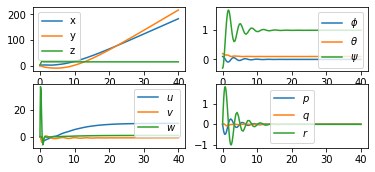

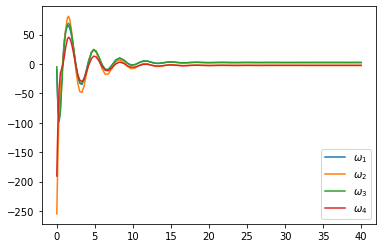

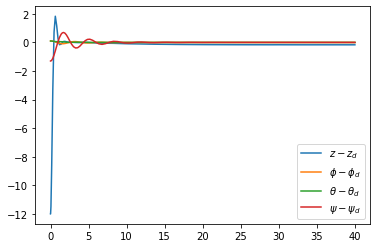

In [94]:
state0 = [0,0,3,0.1,0.2,-0.3,0,0,0,0,0,0]
ctrl(0,state0,traj(0,state0))
sim = solve_ivp(quadrotor,[0,40],state0,max_step=1)
plot_results(sim,ctrl,traj)    